# <center>几何变换在图像处理中有什么用 ？</center>

By [青衣极客 Blue Geek](https://mp.weixin.qq.com/s/eBGlpqvzfZzKAF4VghBjxw)

In 2020-01-18

在数学中，我们常常将几何图形从一个坐标系变换到另外一个坐标，正方形有时变成小正方形，有时会变换成长方形，还有可能会变成平行四边形。在图像处理中，我们常常需要将一幅图像变换成另一幅图像，或者是为了保持大小一致，或者是进行压缩和拉伸，又或者是对一些失真图像进行矫正。那么数学上的几何变换在图像处理中到底有什么作用呢？简单来说，图像变换就是几何变换与像素颜色插值的结果。

我们定义一个原始图像A，想要把图像A变换成图像B的过程分为两步：(1)将图像B中每个像素点的坐标转换为A中对应的坐标点b，这些坐标点b很可能不是整数；(2)然后对这些坐标点b处的像素值进行插值，所谓插值就是根据该坐标附近的A图像像素值估算一个像素值，常见的估算方法有线性内插、曲线内插和区域内插。这里我们不关心具体的内插方法，一般默认都是线性内插，速度较快，精度一般够用。因此，将图像A转换为图像B所需的条件就是：从A坐标到B坐标的变换M和图像A的数据。下面使用OpenCV所提供的接口来演示几种常见图像变换的具体情况。

## 1. 缩放

在图像处理中常常需要将图像进行缩小和放大的处理，有时也需要对图像进行拉伸和压缩，本质上来讲都是改变图像大小的操作。OpenCV提供了resize()函数来实现这种目的。使用该函数进行这种操作时需要注意两点：(1)指定的目标大小必须为整数；(2)指定目标大小列数在前，行数在后，与numpy.array的shape属性相反。该接口封装得非常简单易用，已经看不到几何坐标变换的痕迹了。

<IPython.core.display.Javascript object>


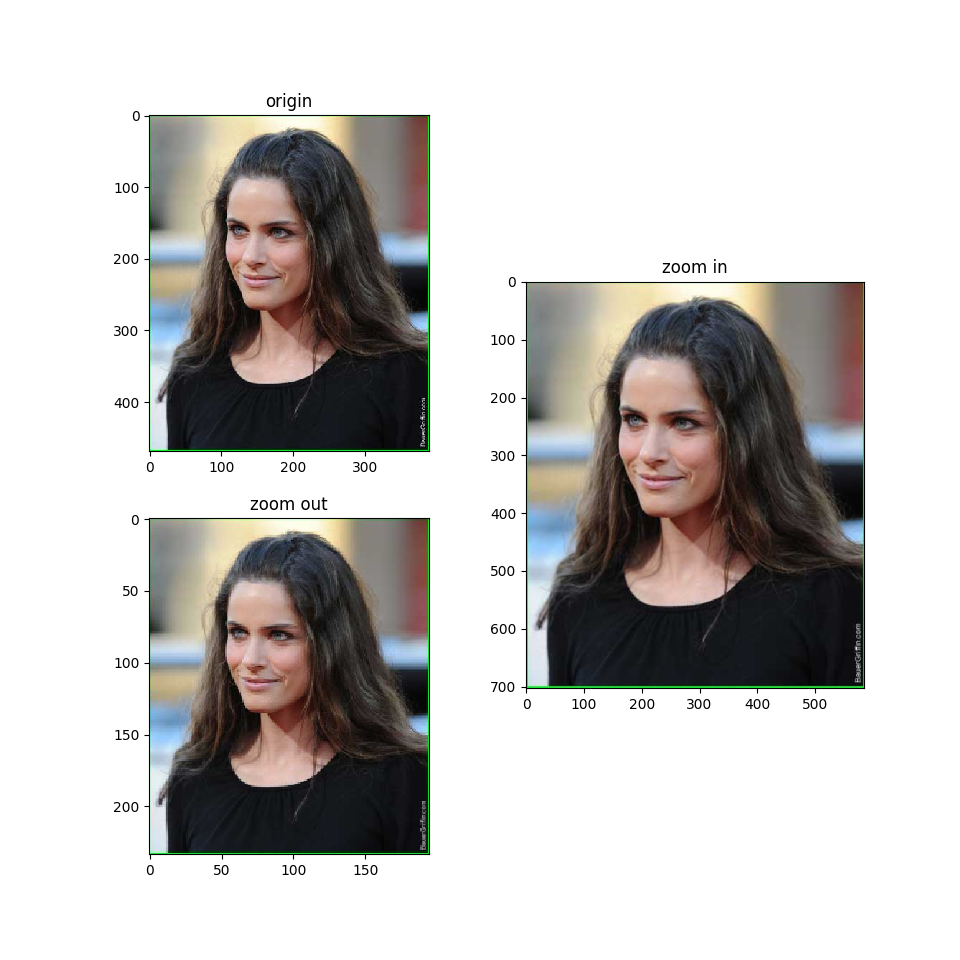

In [45]:
import cv2
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

img_path = '../data/bg61/image_0037.png'
img = cv2.imread(img_path)

plt.figure(figsize=(9.6, 9.6))
plt.subplot(2, 2, 1)
plt.title('origin')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 3)
resize_img = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))
plt.title('zoom out')

plt.subplot(1, 2, 2)
resize_img = cv2.resize(img, (int(img.shape[1]*1.5), int(img.shape[0]*1.5)))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))
plt.title('zoom in')

plt.savefig('../output/bg61/resize.png', dpi=300, bbox_inches='tight')

## 2. 平移

平移变换大概是最简单的变换，即使不明白几何坐标变换原理的朋友，也可以使用最朴素的方式实现。不过，这里既然在讨论图像处理，那么当然是应该使用专业的方式。在描述坐标变换时，为了方程形式的简化，我们一般采用齐次坐标，所谓齐次坐标就是将原有坐标向量扩展一个数值为“1”的维度，也就是说原始的坐标值在齐次坐标下由该维度数值与扩展维度"1"的比值来表示。对于平面上的二维坐标，虽然在齐次坐标下由一个三维向量表示，但是其自由度仍然是2。

对于一个从A到B的平移(tx, ty), 在A中的A‘点经变换后对应在B中的B’点，其变换矩阵如下：
$$
M = \left[ \begin{matrix}
   1 & 0 & tx \\
   0 & 1 & ty \\
   0 & 0 & 1
  \end{matrix}\right]
$$
需注意：在图像坐标系中，x轴的正方向向右，y轴的正方向向下，与通常数学中的坐标系稍有不同。在二维变换下常常将矩阵的最后一行省略。

在OpenCV中，提供了warpAffine()函数接口作为图像几何变换的实现方式，该方法除了指定原始图像和所做变换之外，还需要指定一下目标图像的大小。

<IPython.core.display.Javascript object>


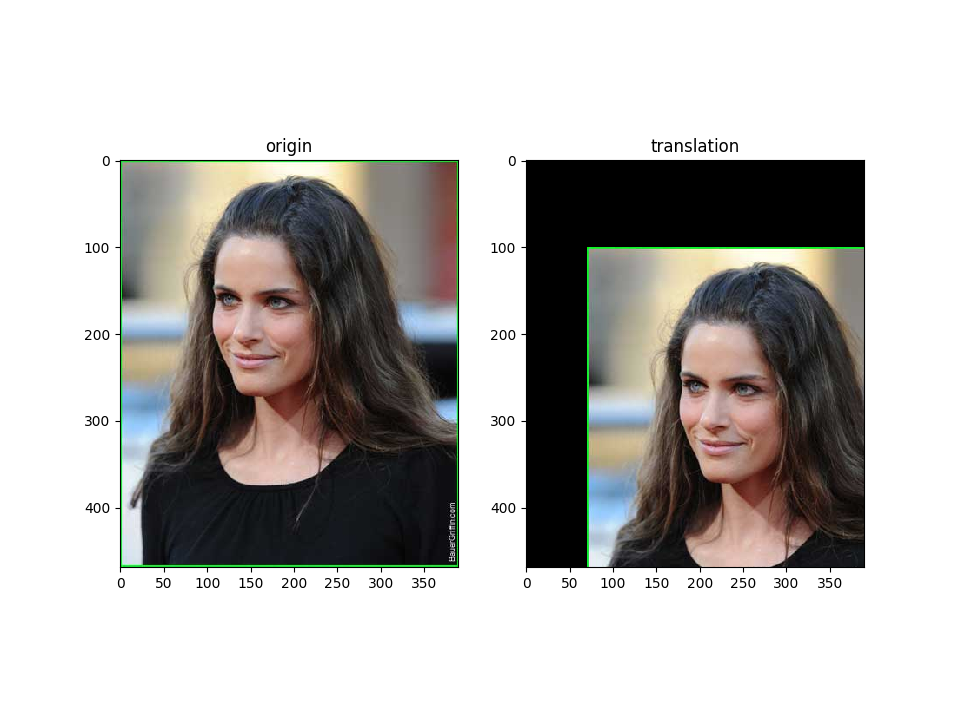

In [46]:
plt.figure(figsize=(9.6, 7.2))
plt.subplot(1, 2, 1)
plt.title('origin')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
M = np.array([[1.0, 0.0, 70.0],[0.0, 1.0, 100.0]], dtype=np.float32)
trans_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(trans_img, cv2.COLOR_BGR2RGB))
plt.title('translation')
plt.savefig('../output/bg61/trans.png', dpi=300, bbox_inches='tight')

## 3. 旋转

旋转可能就没有平移变换那么直观，特别是在这样一个与通常数学坐标系稍有差异的图像坐标系中。我们希望将图像逆时针旋转45度，在图像坐标系中恰恰是顺时针旋转45度。好在OpenCV提供了getRotationMatrix2()函数接口来代理这个思考过程。我们只需要将目标大小，直观的图像旋转角度和尺度因子传入函数，即可得到想要的变换矩阵。从数学上看，旋转和平移联合起来的变换矩阵应该如下：
$$
M = \left[
        \begin{matrix}
          cos\theta & -sin\theta & tx\\
          sin\theta & cos\theta  & ty\\
          0         & 0          & 1
        \end{matrix}
    \right]
$$
其中$\theta$为图像坐标系下的旋转角，这里的tx和ty已经不再表示真实的平移量，真实的平移量需要由矩阵运算得到。如果只是进行平移和旋转，那么就可以称为刚体变换，该变换保证了原有图像中元素之间的距离和角度不变，从变换矩阵可以看出刚体变换有3个自由度。如果有尺度上变换，则变换可以表示如下：
$$
M = \left[
        \begin{matrix}
          scale\cos\theta & -scale\sin\theta & tx\\
          scale\sin\theta & scale\cos\theta  & ty\\
          0         & 0          & 1
        \end{matrix}
    \right]
$$
其中的scale就是表示尺度的因子。这种平移旋转加上尺度的变换称为相似变换，该变换能够保证图像元素之间的角度不变，从变换矩阵可以看出相似变换有4个自由度。

<IPython.core.display.Javascript object>


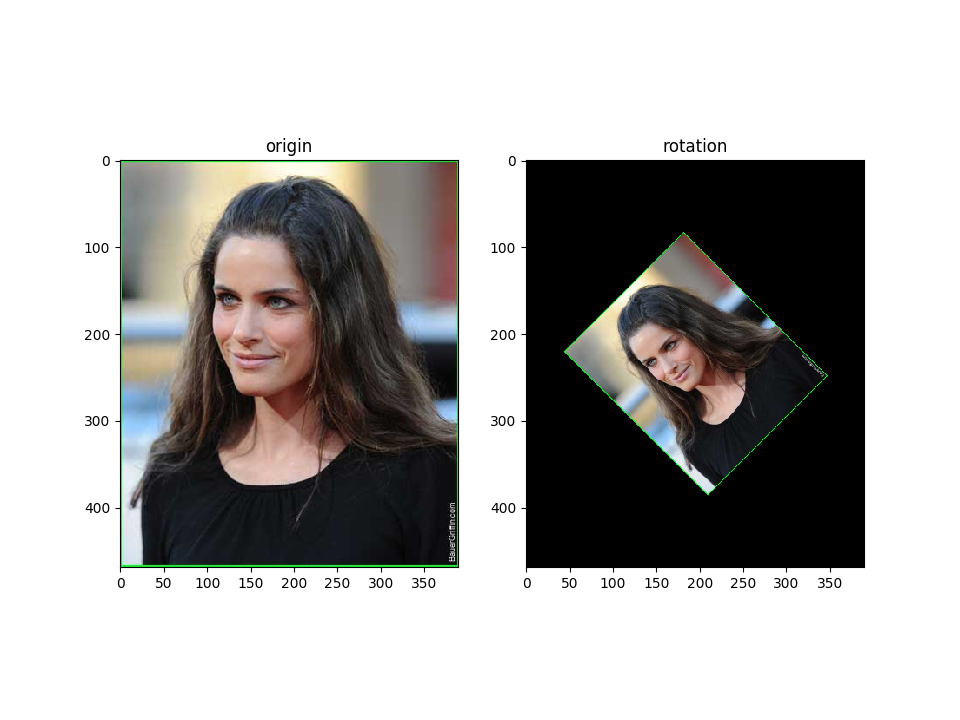

[[  0.35355339   0.35355339  43.32559544]
 [ -0.35355339   0.35355339 220.21141777]]


In [47]:
plt.figure(figsize=(9.6, 7.2))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('origin')

plt.subplot(1, 2, 2)
M = cv2.getRotationMatrix2D((int(img.shape[1]/2), int(img.shape[0]/2)), 45, 0.5)
print(M)
rot_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(rot_img, cv2.COLOR_BGR2RGB))
plt.title('rotation')
plt.savefig('../output/bg61/rotation.png', dpi=300, bbox_inches='tight')

## 4. 仿射

除了以上所讨论的刚体变换(等距变换)和相似变换，有时还需要对图像进行一种变换来矫正图像中元素存在的角度扭曲。而在几何变换中，有一种仿射变换可以在很多场合下达到这种目的，因为仿射变换具有保平行的特性，即该变换虽然无法保证距离和角度，但是对于变换前平行的元素能够保证在变换之后仍然平行。仿射变换的变换矩阵如下：
$$
M = \left[
        \begin{matrix}
            m1 & m2 & m3\\
            m4 & m5 & m6\\
            0  & 0  & 1 
        \end{matrix}
    \right]
$$
其中m1-m6都是待确定的参数，因此仿射变换有6个自由度。因此，在源坐标系和目标坐标系中，至少需要3对匹配点对才能求解出一个仿射变换。

下面展示的例子就是通过图像中左右眼和鼻尖这三个匹配点对求解一个变换，将原始图像中的人脸变换到目标图像的位置。

<IPython.core.display.Javascript object>


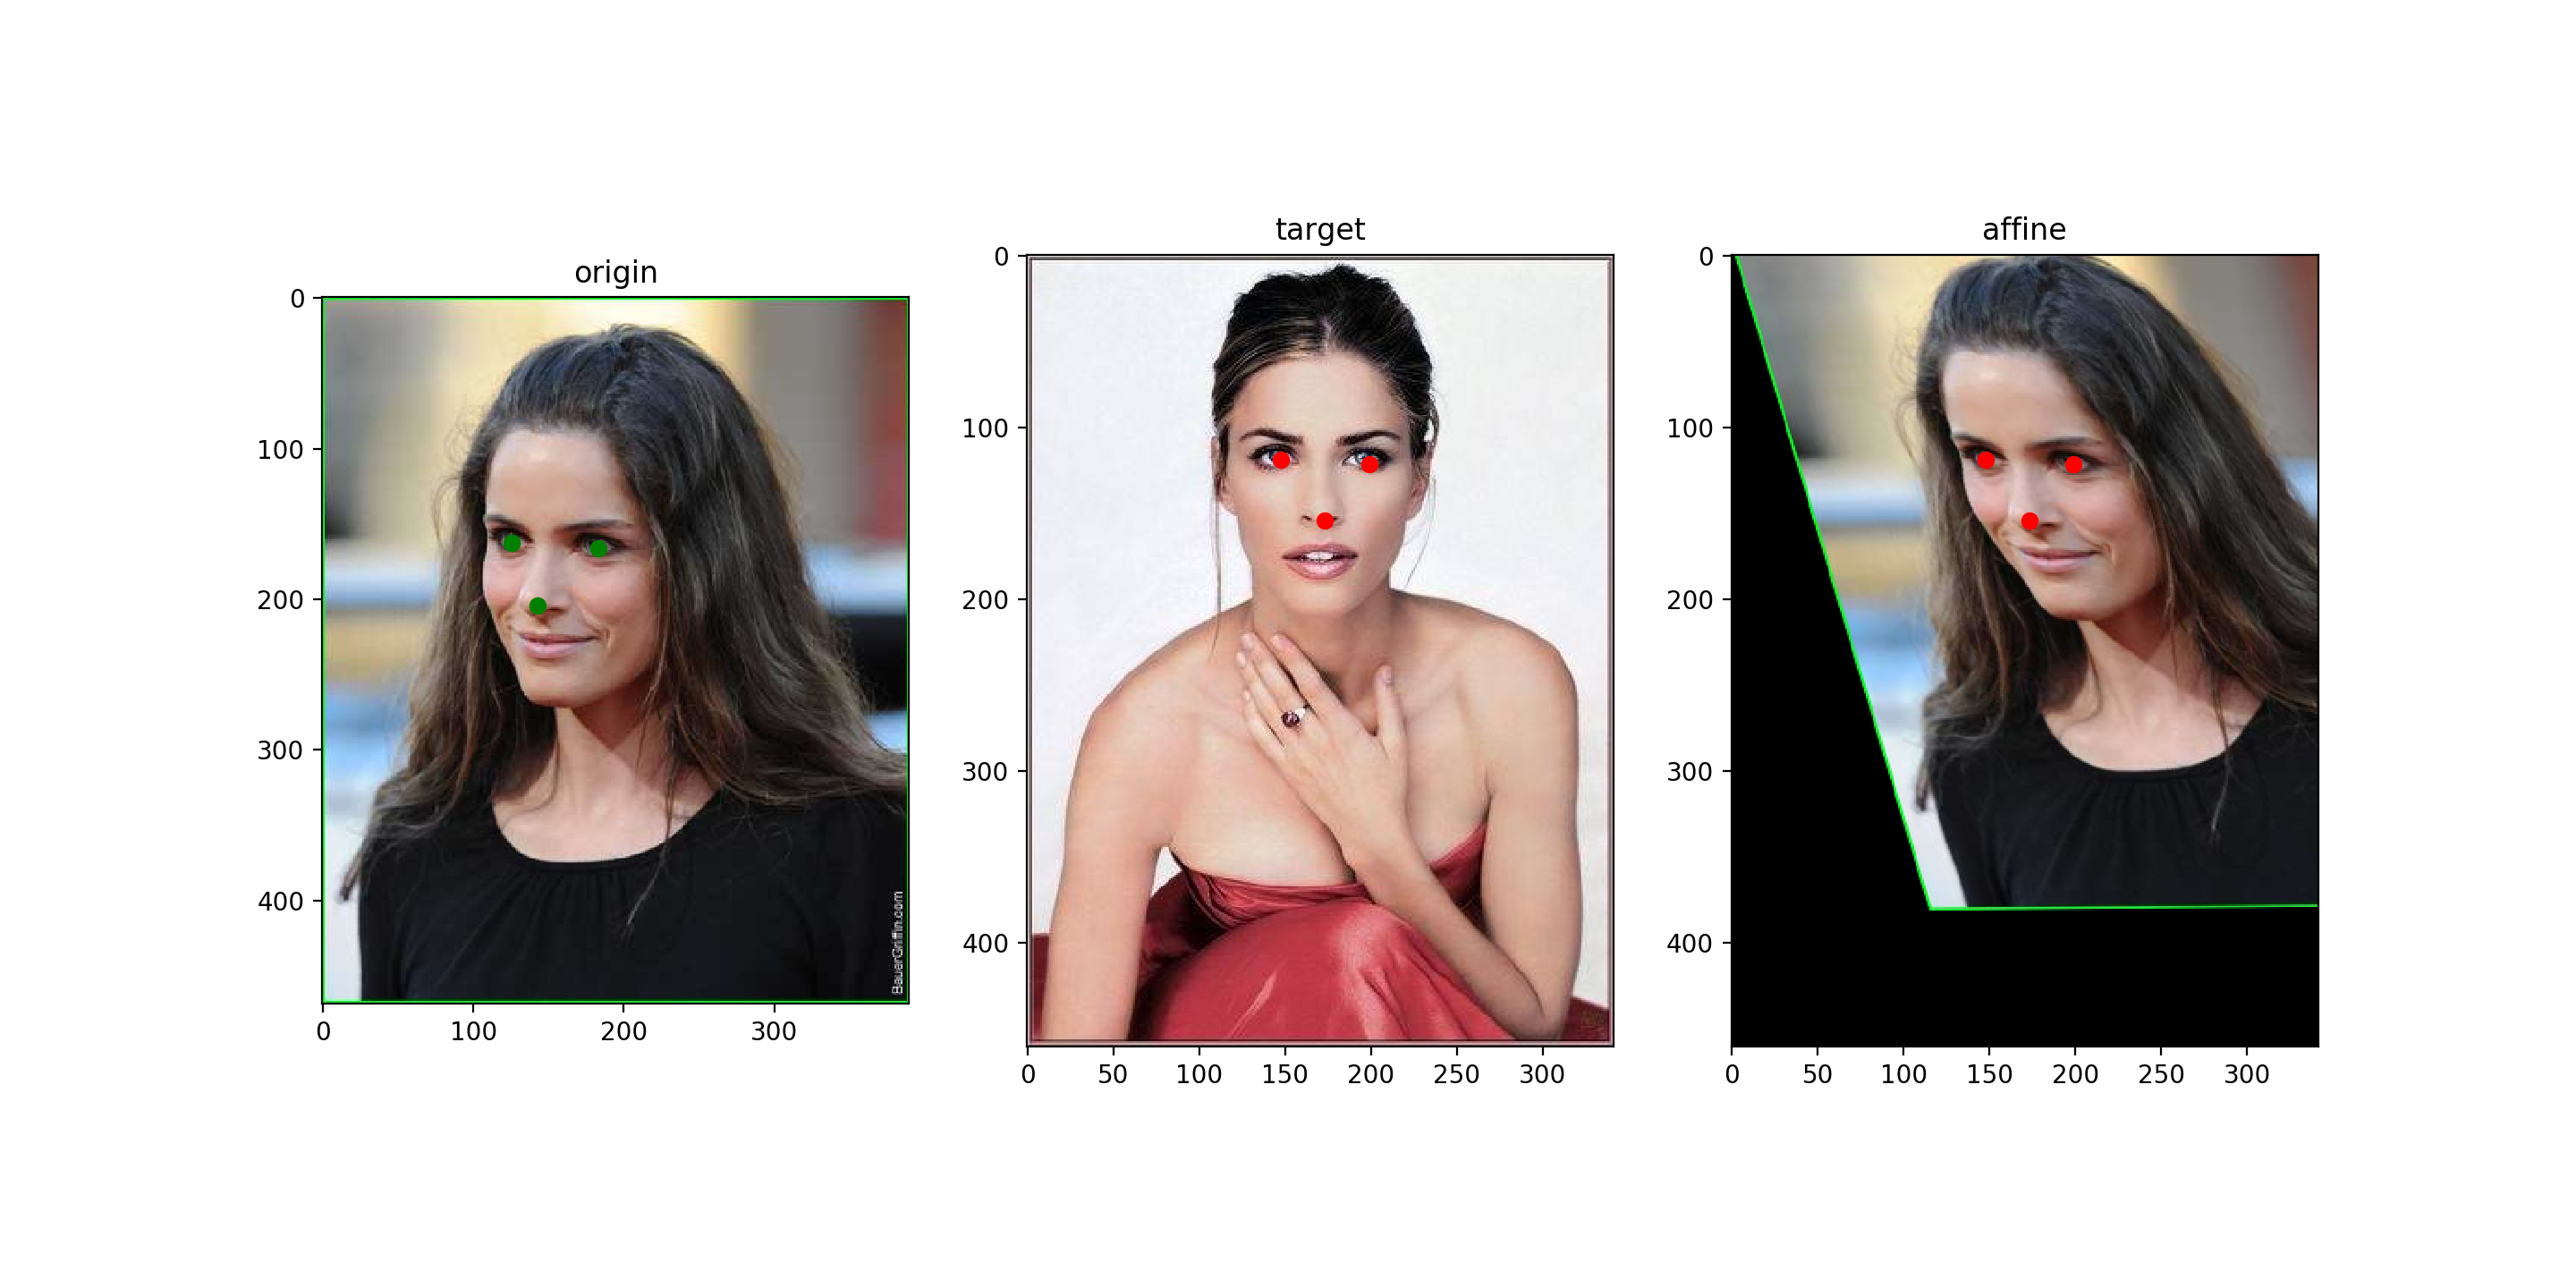

[[ 8.77163595e-01  2.53616163e-01 -3.68357948e+00]
 [-8.48328288e-03  8.54138703e-01 -1.85483180e+01]]


In [50]:
target_img = cv2.imread('../data/bg61/image_0034.png')
plt.figure(figsize=(14.4, 7.2))
# 原始图像
plt.subplot(1,3,1)
ori_pts = np.float32([[125.4,162.4],[183.1,165.9],[142.7,203.9]])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('origin')
plt.plot(ori_pts[:, 0], ori_pts[:, 1], 'o', c='green')
# 参照的目标图像
plt.subplot(1,3,2)
std_pts = np.float32([[147.5,119.1],[199.0,121.6],[173.2,154.4]])
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.title('target')
plt.plot(std_pts[:, 0], std_pts[:, 1], 'o', c='red')
# 变换之后的图像
plt.subplot(1,3,3)
M = cv2.getAffineTransform(ori_pts, std_pts)
print(M)
std_img = cv2.warpAffine(img, M, (target_img.shape[1], target_img.shape[0]))
plt.imshow(cv2.cvtColor(std_img, cv2.COLOR_BGR2RGB))
plt.title('affine')
plt.plot(std_pts[:, 0], std_pts[:, 1], 'o', c='red')
plt.savefig('../output/bg61/affine.png', dpi=300, bbox_inches='tight')

## 5. 透视

透视原理是视觉系统的基本原理，通俗地说就是远处的小、近处的大。我们的眼睛就是通过透视原理将三维空间中的物体投射到视网膜这个二维目标上的。同样，相机也是如此，则我们在研究相机时常常需要建立相机模型，其实际就是建立一个透视模型。事实上，上面所讨论的刚体变换、相似变换以及仿射变换都是透视变换的特殊情况。也就是说，透视变换是更加一般化的变换，其变换矩阵如下：
$$
M = \left[
        \begin{matrix}
            m1 & m2 & m3\\
            m4 & m5 & m6\\
            m7 & m8 & 1 
        \end{matrix}
    \right]
$$
其中m1-m8都是待定的参数，即一般化的透视变换具有8个自由度。求解一个透视变换需要已知原始坐标到目标坐标下的至少4个匹配点对。下面的演示就是指定左右眼和左右嘴角的4个匹配点对来计算一个透视变换。
OpenCv提供了getPerspectiveTransform()函数接口从4个匹配点对计算一个透视变换矩阵，还提供了warpPerspective()函数来执行透视变换。
透视变换常常会出现一些比较夸张的情况，这也是制作相应效果时所需的。

<IPython.core.display.Javascript object>


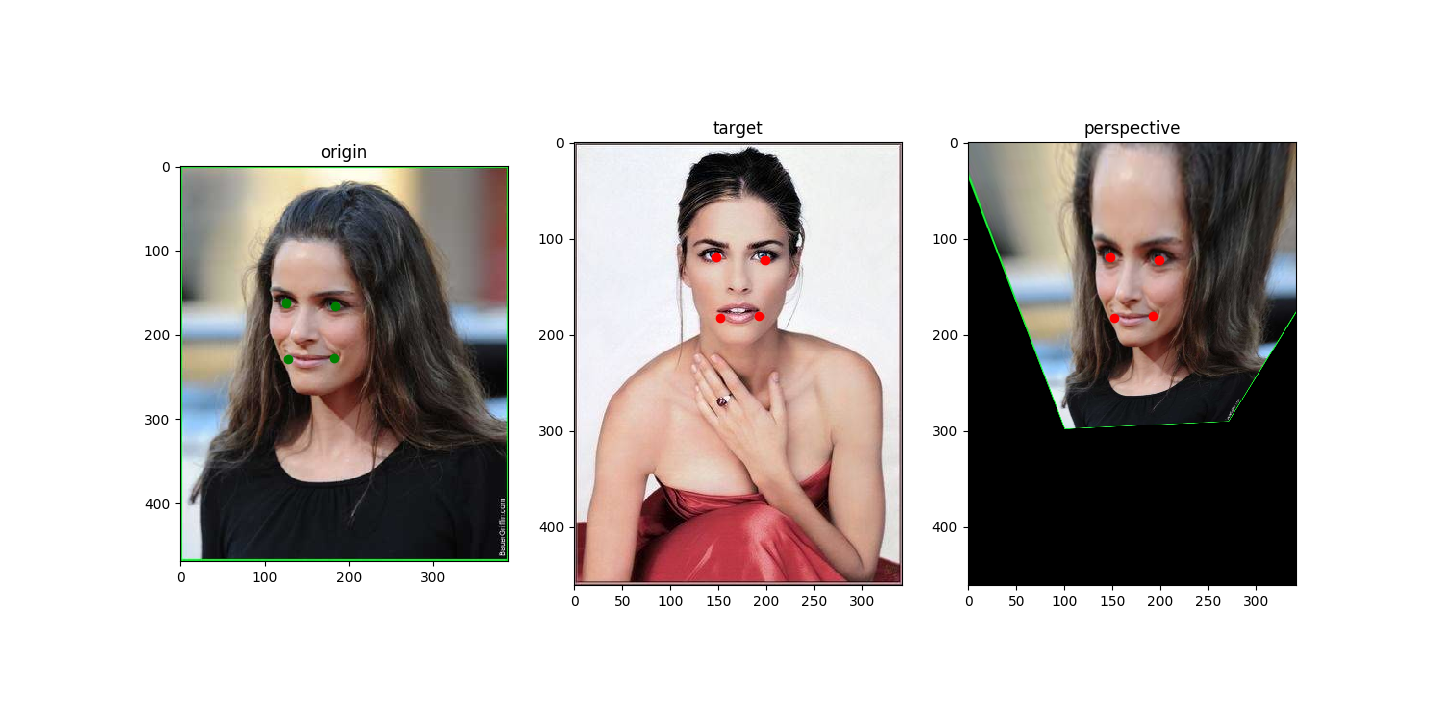

[[ 2.12140564e+00  1.29910279e+00 -1.35421278e+02]
 [-4.20954234e-02  3.69057381e+00 -3.18261222e+02]
 [ 1.86972531e-04  7.95770812e-03  1.00000000e+00]]


In [49]:
target_img = cv2.imread('../data/bg61/image_0034.png')
plt.figure(figsize=(14.4, 7.2))
plt.subplot(1,3,1)
ori_pts = np.float32([[125.4,162.4],[183.1,165.9],[127.7,228.2],[181.9,227.0]])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('origin')
plt.plot(ori_pts[:, 0], ori_pts[:, 1], 'o', c='green')

plt.subplot(1,3,2)
std_pts = np.float32([[147.5,119.1],[199.0,121.6],[152.1,182.6],[192.0,180.2]])
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.title('target')
plt.plot(std_pts[:, 0], std_pts[:, 1], 'o', c='red')

plt.subplot(1,3,3)
M = cv2.getPerspectiveTransform(ori_pts, std_pts)
print(M)
std_img = cv2.warpPerspective(img, M, (target_img.shape[1], target_img.shape[0]))
plt.imshow(cv2.cvtColor(std_img, cv2.COLOR_BGR2RGB))
plt.title('perspective')
plt.plot(std_pts[:, 0], std_pts[:, 1], 'o', c='red')
plt.savefig('../output/bg61/perspective.png', dpi=300, bbox_inches='tight')

以上就是几何变换在图像处理中的几种常见情况，一般而言，缩放、平移旋转和仿射变换更加常用一些，透视变换由于其自由度过高常常求解出夸张的效果而不太常用。对于视觉中的几何问题感兴趣的朋友，还可以继续阅读《计算机视觉中的多视图几何》这本书。